In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPooling2D,Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report
import os
import cv2

# Read Data

In [2]:
labels = os.listdir('~/Desktop/train')

In [3]:
labels

['Closed', 'no_yawn', 'yawn', 'Open']

# Data Exploring

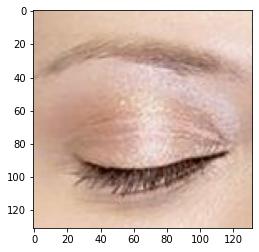

In [24]:
#import random photo from a random file
plt.imshow(plt.imread("~/Desktop/train/Closed/_2.jpg"))

In [25]:
#import random photo from a random file
img = plt.imread("~/Desktop/train/Closed/_2.jpg")
img.shape

(131, 132, 3)

In [7]:
a = plt.imread("~/Desktop/train/yawn/2.jpg")
a.shape

(480, 640, 3)

In [29]:
a = plt.imread("~/Desktop/train/no_yawn/1067.jpg")
a.shape

(480, 640, 3)

In [31]:
a = plt.imread("~/Desktop/train/Open/_22.jpg")
a.shape

(108, 138, 3)

# Data Preprocessing

### A function to go through images and focus only on the face if the person in the image is yawning or not

In [34]:
def face_for_yawn(direc="~/Desktop/train/", face_cas_path="../input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_default.xml")
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no

In [36]:
#Print the index of each class as 0 for yawning and 1 for not yawning
yawn_no_yawn = face_for_yawn()

0
1


### A function to go through images and focus only on the eyes if they were closed or open

In [33]:
def get_data(dir_path="~/Desktop/train/", face_cas="../input/prediction-images/haarcascade_frontalface_default.xml", eye_cas="../input/prediction-images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [37]:
#Print the index of each class as 2 for closed and 3 for open
closed_open = get_data()

2
3


In [38]:
#append both functions to have four class 0,1,2 and 3
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [40]:
classes = append_data();

0
1
2
3


/var/folders/8g/xnwb819n62n3vzd_bphz159w0000gn/T/ipykernel_6695/2869680620.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


### Separate features and labels in our new data 

In [41]:
X = []
y = []
for feature, label in classes:
    X.append(feature)
    y.append(label)

In [52]:
#Transform our X into a numpy array so we can reshape
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# Label Binarizer

#### label binarized were used to transform multi-class labels to binary labels

In [54]:
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [55]:
y = np.array(y)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)

In [58]:
print(f'The length of X test is {len(X_test)}')

The length of X test is 578


# Data Augmentation

#### Image data augmentation is used to improve model performance

In [60]:
#We have scaled our images and we used so augmentation techniques like flipping and rotating images- 
#to improve the performance of the network and to get a high accuracy

train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)
train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [88]:
def display_examples(images):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i], cmap=plt.cm.binary)
    plt.show()

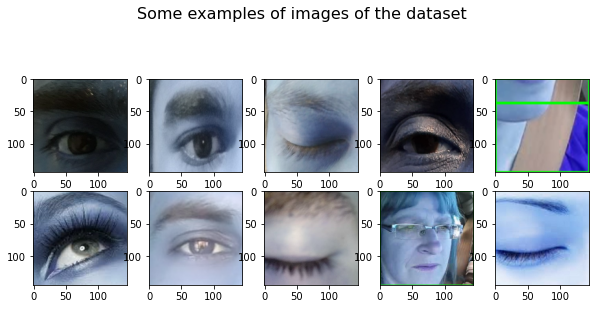

In [89]:
display_examples(X_test)

In [99]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('~/Desktop/train/Closed/_2.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/Users/sultanahaldawsari/Desktop', save_prefix='_2', save_format='jpeg'):
    i += 1
    if i > 20:
        break  

# CNN Building

In [64]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="LeakyReLU", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="LeakyReLU"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="LeakyReLU"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="LeakyReLU"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="LeakyReLU"))
model.add(Dense(4, activation="softmax"))

In [68]:
#To evaluate our network we used to cross entropy for calculating the loss and accuracy as a performance metric and ADAM as an optimizer
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 71, 71, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)      

In [70]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 167s 4s/step - loss: 0.3583 - accuracy: 0.8664 - val_loss: 0.3357 - val_accuracy: 0.8737
Epoch 2/50
43/43 [==============================] - 283s 7s/step - loss: 0.2761 - accuracy: 0.8827 - val_loss: 0.3119 - val_accuracy: 0.8599
Epoch 3/50
43/43 [==============================] - 144s 3s/step - loss: 0.2729 - accuracy: 0.8894 - val_loss: 0.2470 - val_accuracy: 0.8824
Epoch 4/50
43/43 [==============================] - 138s 3s/step - loss: 0.2397 - accuracy: 0.8990 - val_loss: 0.2283 - val_accuracy: 0.9083
Epoch 5/50
43/43 [==============================] - 127s 3s/step - loss: 0.2461 - accuracy: 0.8953 - val_loss: 0.2049 - val_accuracy: 0.9170
Epoch 6/50
43/43 [==============================] - 126s 3s/step - loss: 0.2123 - accuracy: 0.9139 - val_loss: 0.1778 - val_accuracy: 0.9343
Epoch 7/50
43/43 [==============================] - 128s 3s/step - loss: 0.2163 - accuracy: 0.9087 - val_loss: 0.1711 - val_accuracy: 0.9256
Epoch 8/50
43

# Visualizing Training Accuracy and Validation Accuracy

In [72]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(15,8))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

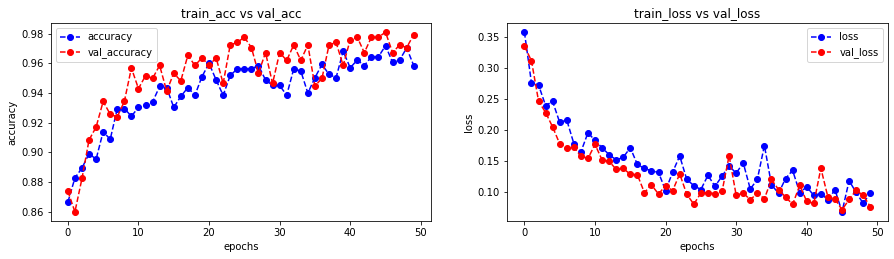

In [73]:
plot_accuracy_loss(history)

In [74]:
model.save("drowsiness.h5")

In [ ]:
model.save("drowsiness.model")

In [75]:
prediction=np.argmax(model.predict(X_test), axis=-1)

# Classification Report

In [77]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145

In [78]:
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.96      0.84      0.90        63
     no_yawn       0.88      0.97      0.92        74
      Closed       0.99      0.99      0.99       215
        Open       0.99      0.99      0.99       226

    accuracy                           0.97       578
   macro avg       0.96      0.95      0.95       578
weighted avg       0.97      0.97      0.97       578



In [109]:
clf_report = classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new,output_dict=True)

<AxesSubplot:>

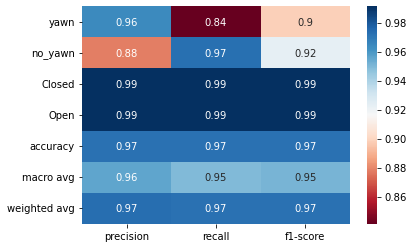

In [111]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap='RdBu')

# Prediction

In [79]:
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowsiness.h5")

Class 3 indicates Open


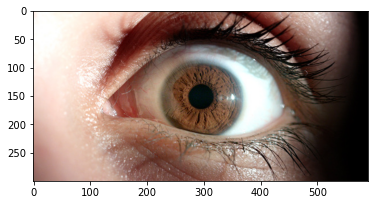

In [80]:
prediction = model.predict([prepare("~/Desktop/image.jpeg")])
print(f'Class {np.argmax(prediction)} indicates Open')
plt.imshow(plt.imread("~/Desktop/image.jpeg"))

Class 1 indicates not yawning


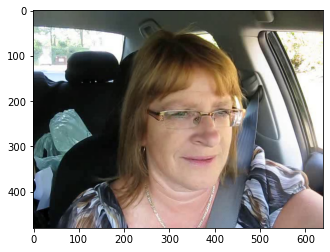

In [112]:
prediction = model.predict([prepare("~/Desktop/train/no_yawn/1067.jpg")])
print(f'Class {np.argmax(prediction)} indicates not yawning')
plt.imshow(plt.imread("~/Desktop/train/no_yawn/1067.jpg"))

Class 2 indicates closed eyes


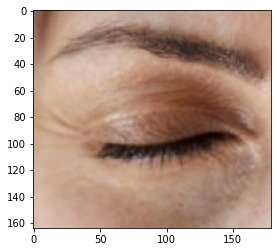

In [113]:
prediction = model.predict([prepare("~/Desktop/train/Closed/_102.jpg")])
print(f'Class {np.argmax(prediction)} indicates closed eyes')
plt.imshow(plt.imread("~/Desktop/train/Closed/_102.jpg"))

Class 1 indicates yawn


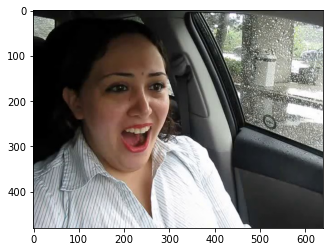

In [114]:
prediction = model.predict([prepare("~/Desktop/train/yawn/102.jpg")])
print(f'Class {np.argmax(prediction)} indicates yawn')
plt.imshow(plt.imread("~/Desktop/train/yawn/102.jpg"))

In [115]:
model.save('model.h5')